In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import multimodal_vae
import torch_mvae_util as U
import util.RAVDESS_dataset_util as Rd
from train_mvae import build_model, train

In [2]:
from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune import JupyterNotebookReporter

In [3]:
num_workers=32
max_num_epochs=50
num_epochs=100
num_samples=20
betas=[0.95, 0.98]
data_dir='/home/studenti/ballerini/datasets/au-emo.csv'
checkpoint_dir='./tuning'

modes={'au':True, 'face':None, 'emotion':True}

config = {
    'batch_size':tune.choice([64, 128, 256, 512]),
    'z_dim':tune.choice([25, 50, 100, 150]),
    'hidden_dim':tune.choice([64, 128, 256, 512]),
    'lr': tune.choice([1e-2, 1e-3, 1e-4, 1e-5]),
    'beta': tune.choice([1e-4, 1e-5, 1e-6, 1e-7]),
    'au_weight':tune.loguniform(1e-3, 1e6),
    'emotion_weight':tune.loguniform(1e-3, 1e6),
}

In [4]:
def load_data(data_dir='./data'):
    au_dataset = pd.read_csv(data_dir).to_numpy()
    au = au_dataset[:,:-1]
    emotions = au_dataset[:,-1].astype(int)-1
    au_dataset = [(x, y) for x, y in zip(au, emotions)]

    trainingset_len = int(len(au_dataset) * 0.8)
    testset_len = len(au_dataset) - trainingset_len

    trainset, testset = torch.utils.data.random_split(
        au_dataset, 
        [trainingset_len, testset_len],
        generator=torch.Generator().manual_seed(66)
    )
    
    return trainset, testset

In [5]:
def hyper_train(config, data_dir, num_epochs, use_cuda=True, checkpoint_dir=None):
    model: torch.nn.Module = build_model(
        cat_dim=8,      
        au_dim=18,     
        latent_space_dim=config['z_dim'],     
        hidden_dim=config['hidden_dim'],               
        num_filters=None,                 
        modes=modes,              
        au_weight=config['au_weight'],           
        emotion_weight=config['emotion_weight'],              
        expert_type='poe',                  
        use_cuda=True).double()
        
    optimizer = torch.optim.Adam(
        params=model.parameters(), 
        lr=config['lr'], 
        betas=betas)
    
    '''    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    '''
    trainset, testset = load_data(data_dir)
    
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])
    
    trainloader = DataLoader(
        trainset, 
        batch_size=config['batch_size'],
        shuffle=True, 
        num_workers=32)

    valloader = DataLoader(
        val_subset, 
        batch_size=config['batch_size'],
        shuffle=True, 
        num_workers=32)
    
    beta = config['beta']
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            au, emotions = data
            
            if use_cuda:
                if au is not None:
                    au = au.cuda()
                if emotions is not None:
                    emotions = emotions.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()
            
            (
                au_reconstruction,
                emotion_reconstruction,
                z_loc_expert,
                z_scale_expert,
                latent_sample
            ) = model(
                au=au,
                emotions=emotions
            )

            loss = model.loss_function(
                au=au,
                emotions=emotions,
                au_reconstruction=au_reconstruction,
                emotions_reconstruction=emotion_reconstruction,
                z_loc=z_loc_expert,
                z_scale=z_scale_expert,
                beta=beta,
                latent_sample=latent_sample
            )
            
            loss["total_loss"].backward()
            optimizer.step()

        y_true = []
        y_pred = []
        val_loss = 0
        val_steps = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                au, emotions = data
            
                if use_cuda:
                    if au is not None:
                        au = au.cuda()
                    if emotions is not None:
                        emotions = emotions.cuda()

                (
                    au_reconstruction,
                    emotion_reconstruction,
                    z_loc_expert,
                    z_scale_expert,
                    latent_sample
                ) = model(
                    au=au,
                    emotions=None
                )
                
                loss = model.loss_function(
                    au=au,
                    emotions=emotions,
                    au_reconstruction=au_reconstruction,
                    emotions_reconstruction=emotion_reconstruction,
                    z_loc=z_loc_expert,
                    z_scale=z_scale_expert,
                    beta=beta,
                    latent_sample=latent_sample
                )
                
                reconstructed_emotions = torch.argmax(emotion_reconstruction, 1)
                y_true += emotions.cpu()
                y_pred += reconstructed_emotions.cpu()
                val_loss += loss['total_loss'].cpu().numpy()
                val_steps += 1
                
        matrix = confusion_matrix(y_true, y_pred)
        accuracy = matrix.diagonal()/matrix.sum(axis=1)
        accuracy = sum(accuracy) / len(accuracy)
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        

        tune.report(loss=(val_loss / val_steps), accuracy=accuracy)
    print("Finished Training")
    

In [7]:
scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    max_t=max_num_epochs,
    grace_period=3,
    reduction_factor=2)    

reporter = JupyterNotebookReporter(
    True,
    metric_columns=["accuracy","loss","training_iteration"])

result = tune.run(
        partial(hyper_train, data_dir=data_dir, num_epochs=num_epochs, checkpoint_dir=checkpoint_dir),
        resources_per_trial={"cpu": 8, "gpu": 0.1},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

best_trial = result.get_best_trial("accuracy", "max", "last")

print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

Trial name,status,loc,au_weight,batch_size,beta,emotion_weight,hidden_dim,lr,z_dim,accuracy,loss,training_iteration
hyper_train_04d9c_00000,TERMINATED,159.149.133.23:861517,15614.8,512,1e-06,23.7237,512,0.0001,100,0.195148,372.162,50
hyper_train_04d9c_00001,TERMINATED,159.149.133.23:861547,501.801,256,1e-06,0.685339,128,1e-05,50,0.126795,545.003,3
hyper_train_04d9c_00002,TERMINATED,159.149.133.23:861549,1715.67,512,0.0001,171.886,128,0.01,50,0.26242,844.355,3
hyper_train_04d9c_00003,TERMINATED,159.149.133.23:861552,0.034634,64,0.0001,60471.9,128,1e-05,25,0.313553,111227,6
hyper_train_04d9c_00004,TERMINATED,159.149.133.23:861553,0.79315,512,0.0001,1176.89,128,0.0001,150,0.333239,2086.83,12
hyper_train_04d9c_00005,TERMINATED,159.149.133.23:861554,70197.2,64,1e-07,53197.4,512,1e-05,50,0.225175,146857,3
hyper_train_04d9c_00006,TERMINATED,159.149.133.23:915137,93488.5,64,1e-05,0.00645051,128,0.01,150,0.247049,6143.36,3
hyper_train_04d9c_00007,TERMINATED,159.149.133.23:921344,3.25485,128,0.0001,0.366391,64,0.0001,150,0.330531,0.801495,6
hyper_train_04d9c_00008,TERMINATED,159.149.133.23:936609,50034.1,64,1e-07,2.55607,64,0.0001,25,0.528251,706.995,50
hyper_train_04d9c_00009,TERMINATED,159.149.133.23:988283,0.00887919,256,1e-05,0.392567,64,0.001,50,0.203191,0.914433,3


2022-07-04 18:24:55,801	INFO tune.py:747 -- Total run time: 352.76 seconds (352.58 seconds for the tuning loop).


Best trial config: {'batch_size': 64, 'z_dim': 25, 'hidden_dim': 64, 'lr': 0.0001, 'beta': 1e-07, 'au_weight': 50034.05640947136, 'emotion_weight': 2.556065361069233}
Best trial final validation loss: 706.9954784199389
Best trial final validation accuracy: 0.528250660580455


In [8]:
best_trial.config

{'batch_size': 64,
 'z_dim': 25,
 'hidden_dim': 64,
 'lr': 0.0001,
 'beta': 1e-07,
 'au_weight': 50034.05640947136,
 'emotion_weight': 2.556065361069233}

In [9]:
model_args = {
    'cat_dim':8,      
    'au_dim':18,     
    'latent_space_dim':best_trial.config['z_dim'],     
    'hidden_dim':best_trial.config['hidden_dim'],               
    'num_filters':None,                 
    'modes':modes,              
    'au_weight':best_trial.config['au_weight'],           
    'emotion_weight':best_trial.config['emotion_weight'],              
    'expert_type':'poe',                  
    'use_cuda':True}

print(model_args)
train_args = {
    'learning_rate' : best_trial.config['lr'],
    'beta': best_trial.config['beta'],
    'optim_betas' : betas,
    'num_epochs' : num_epochs,
    'batch_size' : best_trial.config['batch_size']
}
print(train_args)

{'cat_dim': 8, 'au_dim': 18, 'latent_space_dim': 25, 'hidden_dim': 64, 'num_filters': None, 'modes': {'au': True, 'face': None, 'emotion': True}, 'au_weight': 50034.05640947136, 'emotion_weight': 2.556065361069233, 'expert_type': 'poe', 'use_cuda': True}
{'learning_rate': 0.0001, 'beta': 1e-07, 'optim_betas': [0.95, 0.98], 'num_epochs': 100, 'batch_size': 64}


In [10]:
best_trained_model =  build_model(**model_args).double()

In [11]:
best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))

best_trained_model.load_state_dict(model_state)

<All keys matched successfully>

In [12]:
save_model = False

if save_model:
    PATH = "../trained_models/best_train_moe.save"
    torch.save({'model_args' : model_args,
                'train_args' : train_args,
                'model_state' : model_state
                }, PATH)

100%|████████████████████████████████████████████████████████████████| 2048/2048 [00:05<00:00, 380.40it/s]
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being se

              precision    recall  f1-score   support

     neutral       0.01      0.00      0.00      4100
        calm       0.54      0.33      0.41      3984
       happy       0.82      0.05      0.09      4182
         sad       0.29      0.47      0.36      4242
       angry       0.00      0.00      0.00      4076
     fearful       0.17      0.97      0.29      3981
     disgust       1.00      0.00      0.00      4054
   surprised       0.06      0.00      0.00      4149

    accuracy                           0.22     32768
   macro avg       0.36      0.23      0.14     32768
weighted avg       0.36      0.22      0.14     32768



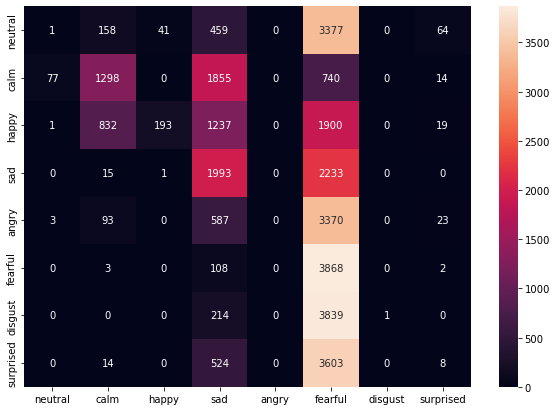

In [13]:
labels = list(Rd.emocat.values())
y_true, y_pred = U.au_recon_and_classiffication_accuracy(best_trained_model, num_samples=2048)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)